In [22]:
import numpy as np
from ephysvibe.structures.trials_data import TrialsData
from ephysvibe.task import task_constants
from matplotlib import pyplot as plt
from collections import defaultdict
import pandas as pd
from typing import Dict

#### Read trials data (sp + bhv)

In [2]:
path = "C:/Users/camil/Documents/int/data/session_struct/Riesling/v4/2023-01-20_11-00-24_Riesling_v4_e1_r1.h5"
data = TrialsData.from_python_hdf5(path)

In [3]:
s=data.sp_samples.shape
print('Number of trials: %d, neurons: %d, timestamps: %d'%(s[0],s[1],s[2]))

Number of trials: 1087, neurons: 26, timestamps: 7983


In [4]:
# select correct trials, block 2, block 1
idx_trials = np.where(data.trial_error == 0)[0]
correct = data.sp_samples[idx_trials]
print('Number of correct trials: %d'%(correct.shape[0]))
idx_trials_b2 = np.where(np.logical_and(data.trial_error == 0, data.block==2))[0]
print('Number of correct trials in block 2: %d'%(data.sp_samples[idx_trials_b2].shape[0]))
idx_trials_b1 = np.where(np.logical_and(data.trial_error == 0, data.block==1))[0]
print('Number of correct trials in block 1: %d'%(data.sp_samples[idx_trials_b1].shape[0]))

Number of correct trials: 486
Number of correct trials in block 2: 80
Number of correct trials in block 1: 406


In [58]:
# Select trials when a specific sample is presented
o1_c1_in=task_constants.SAMPLES_COND['o1_c5_in']
trials_o1_c1_in=np.where(np.logical_and(np.logical_and(data.trial_error == 0, data.block==1),np.in1d(data.condition,o1_c1_in)))[0]


In [59]:
def indep_roll(arr, shifts, axis=1):
    """Apply an independent roll for each dimensions of a single axis.

    Parameters
    ----------
    arr : np.ndarray
        Array of any shape.

    shifts : np.ndarray
        How many shifting to use for each dimension. Shape: `(arr.shape[axis],)`.

    axis : int
        Axis along which elements are shifted. 
    """
    arr = np.swapaxes(arr,axis,-1)
    all_idcs = np.ogrid[[slice(0,n) for n in arr.shape]]

    # Convert to a positive shift
    shifts[shifts < 0] += arr.shape[-1] 
    all_idcs[-1] = all_idcs[-1] - shifts[:, np.newaxis]

    result = arr[tuple(all_idcs)]
    arr = np.swapaxes(result,-1,axis)
    return arr

In [62]:
neurons = np.where(data.clustersgroup == "good")[0]

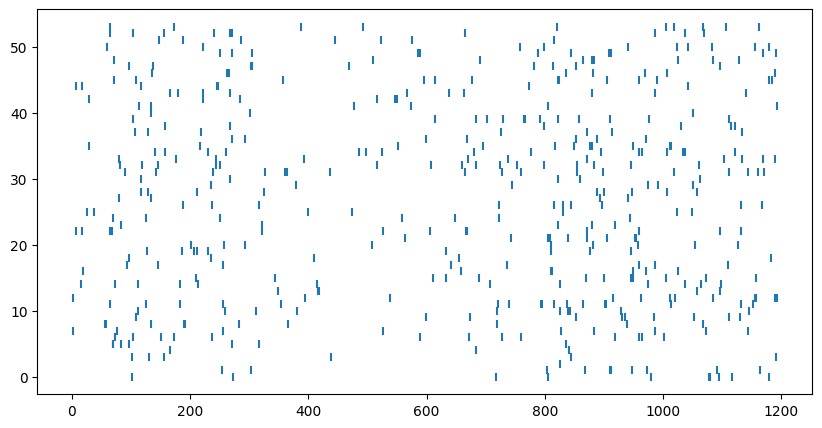

In [63]:
# Plot spikes
idx_sample_on=data.code_samples[trials_o1_c1_in,np.where(data.code_numbers[trials_o1_c1_in]== 23)[1]].astype(int)
neuron = neurons[1]-1
shift_sp = indep_roll(data.sp_samples[trials_o1_c1_in,neuron,:], -(idx_sample_on+1-200), axis=1)[:,:1200]
fig,ax = plt.subplots(figsize=(10,5))
rows,cols = np.where(shift_sp==1)
ax.scatter(cols,rows, marker='|')

In [33]:
task: Dict[str, list] = defaultdict(list)
for key_cond, n_cond in task_constants.SAMPLES_COND.items():
    idx = np.where(np.in1d(data.condition[idx_trials_b1],n_cond))[0]
    n_test_stimuli = np.sum(~np.isnan(data.test_stimuli[idx_trials_b1[idx]]),axis=1)
    code = 7 - (n_cond[-1] - data.condition[idx_trials_b1[idx]])
    sample = np.where(np.logical_and(code==7,n_test_stimuli==5),"o0_c0",key_cond[:5])
    
    task["trial_idx"] += idx.tolist()
    task["sample"] += sample.tolist()
    task["in_out"] += [key_cond[6:]]*len(idx)
    task["n_test_stimuli"] += n_test_stimuli.tolist()
    task["code"] += code.astype(int).tolist()
pd.DataFrame(task)

In [38]:
data.clustersgroup.shape

(26,)

In [11]:
data.test_distractor[idx_trials_b1]

array([[81., 52., 88., 33., 16.],
       [32., 36., nan, nan, nan],
       [22., 58., 23., 52., 64.],
       ...,
       [27., 48., nan, nan, nan],
       [66., nan, nan, nan, nan],
       [24., 74., nan, nan, nan]])

#### eyes

In [ ]:
zero = np.nanargmin(np.abs(data.eye_ml[1,:,0]))
tmp = np.where(np.abs(data.eye_ml[1,:,0])<=1)[0]
one = tmp[np.nanargmin(data.eye_ml[1,tmp,0])]
if data.eye_ml[1,one,0]<0:
    mf = -1
else:
    mf = 1
oezero = data.eyes_values[1,0,1000+zero]
oeone = data.eyes_values[1,0,1000+one]
slope = oeone - oezero
plt.plot(data.eye_ml[1,:,0])
plt.plot((data.eyes_values[0,1,1000:]-oezero)/np.abs(slope))